In [2]:
# list of temps I held the simulation at
temperatures = [400, 300, 290, 280, 270, 260, 250, 240, 230]

# temperature mixture
electrolyte_mixtures = [
    {
        'solute_n_moles': 1.0, 
        'solute_symbol': 'LiPF6', 
        'solvent_composition_by_volume': 
        {
            'CEE': 1.0, 
            'MPN': 0.0
        }
    }
]

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [4]:
class LammpsThermoOutputFile():
    DEFAULT_TAGS = ["step", "time", "temp", "press", "pe", "ke", "etotal","lx", "ly", "lz", "xy", "xz", "yz", "pxx", "pyy", "pzz", "pxy", "pxz", "pyz", "density"]
    INTEGER_TAGS = ["step", "time"]
    def __init__(self, tags=None):
        self.tags = None
        self.data_df: pd.DataFrame = None
        if tags is None:
            self.tags = LammpsThermoOutputFile.DEFAULT_TAGS
        else:
            self.tags = tags
            
    def read(self, path):
        # initialize storage array
        data = []

        # read in the lines
        with open(path, 'r') as f:
            lines = f.readlines()

        # process lines one by one
        for line in lines:
            if not line.startswith("#"):
                # from each line strip the endline into tokens on spaces
                # for each token k strip whitespace
                args = [k.strip() for k in line.strip().split()]
                
                # concatenate to the storage array
                data.append(args)
        
        # store data into a dataframe
        self.data_df = pd.DataFrame(data=data, columns=self.tags)
        
        # types are all currently strings
        # we expect all types to be floats except for INTEGER_TAG_TYPES
        for i in range(len(LammpsThermoOutputFile.DEFAULT_TAGS)):
            n = LammpsThermoOutputFile.DEFAULT_TAGS[i]
            
            if n in LammpsThermoOutputFile.INTEGER_TAGS:
                # convert int types to int
                self.data_df[n] = self.data_df[n].astype(int)
            else:
                # convert float types to float
                self.data_df[n] = self.data_df[n].astype(float)


In [5]:
project_path = "001_LiPF6_CEE/nptrelax.2CEE.100"
project_path_exists = os.path.isdir(project_path)
print(f"project_path={project_path}")
print(f"project_path_exists={project_path_exists}")

project_path=001_LiPF6_CEE/nptrelax.2CEE.100
project_path_exists=True


In [6]:
mixture = electrolyte_mixtures[0]
nptrelax_path = project_path
nptrelax_path_exists = os.path.isdir(nptrelax_path)
print(f"nptrelax_path={nptrelax_path}")
print(f"nptrelax_path_exists={nptrelax_path_exists}")

nptrelax_path=001_LiPF6_CEE/nptrelax.2CEE.100
nptrelax_path_exists=True


In [7]:
temp1 = 280
temp2 = 280
fileout_path = os.path.join(nptrelax_path, f'system.nptrelax.{temp1}K.{temp2}K.out')
fileout_output_tags = ["step", "time", "temp", "press", "pe", "ke", "etotal","lx", "ly", "lz", "xy", "xz", "yz", "pxx", "pyy", "pzz", "pxy", "pxz", "pyz", "density"]
print(f"fileout_path={fileout_path}")
print(f"fileout_path_exists={os.path.isfile(fileout_path)}")

fileout_path=001_LiPF6_CEE/nptrelax.2CEE.100/system.nptrelax.280K.280K.out
fileout_path_exists=True


In [8]:
# use an object to read the file
file = LammpsThermoOutputFile()   # instatiate the object
file.tags = fileout_output_tags
file.read(path=fileout_path)      # read the file using .read() method



In [22]:
# average of lx
mu = np.mean(file.data_df['lx'])
# standard deviation of lx
sigma = np.std(file.data_df['lx'])

print(f"mu={mu}")
print(f"sigma={sigma}")

mu=57.46182398953854
sigma=0.03702292106603103


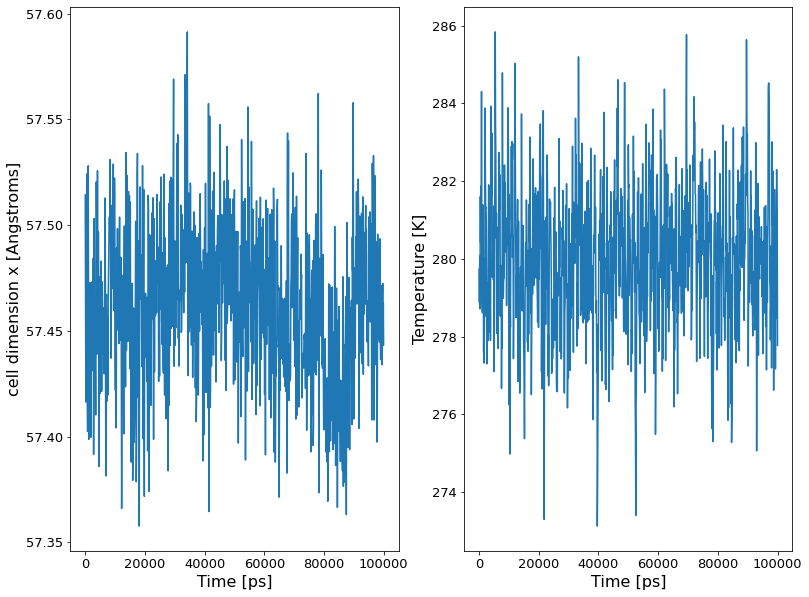

In [17]:
time_min = min(file.data_df['time'])
time_max = max(file.data_df['time'])

fig1 = plt.figure()
fig1.set_size_inches(20,10)
ax1 = fig1.add_subplot(131)
ax1.plot(file.data_df['time'], 
         file.data_df['lx'])
ax1.set_xlabel("Time [ps]", fontsize=16)
ax1.set_ylabel("cell dimension x [Angstroms]", fontsize=16)
ax1.tick_params(axis='x', labelsize=13)
ax1.tick_params(axis='y', labelsize=13)

ax2 = fig1.add_subplot(132)
ax2.plot(file.data_df['time'],
         file.data_df['temp'])
ax2.set_xlabel("Time [ps]", fontsize=16)
ax2.set_ylabel("Temperature [K]", fontsize=16)
ax2.tick_params(axis='x', labelsize=13)
ax2.tick_params(axis='y', labelsize=13)


In [23]:
lx = []    # initializing storage array
T = []     # initializing temperature array
for temp in temperatures:
    # Ignore 400K data because it is still approaching thermal equilibrium; data not good
    if temp != temperatures[0]:
        # Traverse through all temperature holding .out files except 400K.400K.out
        file_path = os.path.join(
                nptrelax_path,
                 'system.nptrelax.{}K.{}K.out'.format(temp, temp)
        )
        
        # read the file, organize tags
        file = LammpsThermoOutputFile()
        file.tags = fileout_output_tags
        file.read(path=file_path)

        # store lx
        lx.append(
            [
                np.mean(file.data_df['lx']),
                np.std(file.data_df['lx'])
            ]
        )
        
        # store temperature array
        # same as temperatures[] but without 400K
        T.append(temp)
              


In [24]:
# Creating a Pandas DataFrame with the values from lx: mean lx and standard deviation lx
# Organize into 2 columns, mean, standard deviation
x_df = pd.DataFrame(lx, columns=['mu_x', 'std_x'])

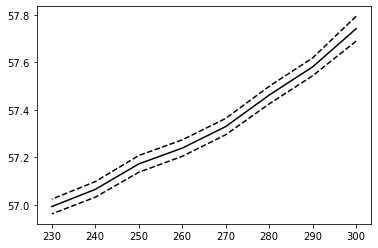

In [25]:
# Plot means of lx as a solid, black line
# Plot positive and negative standard deviations of lx as dashed lines
plt.plot(T,x_df['mu_x'], c='black')
plt.plot(T,x_df['mu_x'] + x_df['std_x'], c='black', linestyle="--")
plt.plot(T,x_df['mu_x'] - x_df['std_x'], c='black', linestyle="--")

In [26]:
# Because plot did not have definite/good linear regression within stdv bounds
# Use means of lx for each temperature
for i in range(len(T)):
    print(f"{T[i]}:{x_df['mu_x'][i]}")

300:57.74132052420761
290:57.580736759758175
280:57.46182398953854
270:57.32932061542861
260:57.2386769230362
250:57.172186757034886
240:57.06489173146891
230:56.99274463047446
